### H&M product recommendation system using Alternating Least Square algorithm from Implicit library

**A brief introduction to recommender system:**

Recommender systems have two major categories, namely Content-Based recommender and Collaborative Filtering system. Content-Based method relies on data of user attributes and item features. Collaborative Filtering system relies on user-item interaction data, such as ratings, and browsing behaviors, purchase history, and so on. We recommend items to users not only based on a user's previous purchase history or rating score, but we also consider other users' preferences. There is another Hybrid System which combines the advantages of these two approaches.

To build a collaborative filtering system, we need to construct a user-item interaction matrix, the row is the user ID, and the column is the item ID, the value is the rating a user gives to an item, or 1 if the user purchased the item, and 0 if not. That is all we need to build a collaborative filtering system. We don't need other features.

The user-item interaction matrix is a sparse matrix, the majority of the values are either missing or 0. From this interaction matrix, we can build either item-based or user-based collaborative filtering system based on the similarity between items or users. However, this approach has some shortcomings:
* popularity bias: such recommender tends to recommend popular items
* item cold-start problem: recommender fails to recommend new or less-known items because items have either none or very little interactions
* scalability issue: lack of the ability to scale to much larger datasets when more and more users and items added into our database

To solve these problems, we can use Matrix Factorization technique. It decomposes the interaction matrix into the product of two lower dimension matrices, namely user matrix and item matrix. For the user matrix, rows represent users and columns are latent factors. For the item matrix, rows are latent factors and columns represent items.

In collaborative filtering, matrix factorization is the state-of-the-art solution for sparse data and cold-start problem:
* Model learns to factorize user-item interaction matrix into user and item matrices, and also learns the coefficients for all the latent factors of the user matrix and item matrix, respectively, based on already known user-item interactions. Then we calculate the product of these two matrices to restore the user-item interaction matrix. This time, the 0s (or missing values) are filled with numbers, which allows model to predict better personalized items for users.
* So, with matrix factorization, less-known items can have rich latent factors as much as popular items have, which improves recommender’s ability to recommend less-known items. In this way, the cold-start problem is largely solved.

We can regard the latent factors for user matrix as hidden user attributes, and latent factors for item matrix as hidden item features.

For this project, we first tried to build a collaborative filtering system using Alternating Least Square (ALS) algorithm which is based on matrix factorization technique. 

https://sophwats.github.io/2018-04-05-gentle-als.html

The goal of Alternating Least Squares is to find two matrices, user matrix U and item matrix I, such that their product approximately equals to the original user-item interaction matrix. Once such matrices have been found, we are able to predict what user i will think of item j by multiplying row i of U with row j of I.

When computing U and I using ALS, we do it in an alternating way, thus the term "Alternating" term:
* fix matrix U and find the optimal matrix I
* fix matrix I and find the optimal matrix U

To find the optimal matrix, we use least square optimization technique by minimizing the least squares error function (plus some regularisation term which prevents overfitting), thus the term Least Squares.

The goal of the project is, for each customer, we predict 12 products which the customer will most likely buy in 7 days after the last transaction in the training data. 

The evaluation metric for our ALS recommender will be Mean Average Precision @ 12. Here we want to avoid recommending any item that a user will not purchase. So, we want to have a low false positive. That translates into a high precision.

In [1]:
# import all necessary libraries

import os
import pandas as pd
import numpy as np

import implicit
from scipy.sparse import coo_matrix
from implicit.evaluation import mean_average_precision_at_k
from implicit.nearest_neighbours import bm25_weight

import matplotlib.pyplot as plt
%matplotlib inline

**Load all datasets:**

In [2]:
df_trans = pd.read_csv('data/transactions_train.csv', dtype={'article_id': str}, parse_dates=['t_dat'])
df_trans

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1


In [3]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        object        
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.2+ GB


***No missing values, T_dat convertd to datetime type. The original article_id is of the type int64. In order to keep the leading '0', convert it to type str.***

In [4]:
df_user = pd.read_csv('data/customers.csv')
df_user

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN,NaN,ACTIVE,NONE,24.0,7aa399f7e669990daba2d92c577b52237380662f36480b...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN,NaN,ACTIVE,NONE,21.0,3f47f1279beb72215f4de557d950e0bfa73789d24acb5e...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,1.0,1.0,ACTIVE,Regularly,21.0,4563fc79215672cd6a863f2b4bf56b8f898f2d96ed590e...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,1.0,1.0,ACTIVE,Regularly,18.0,8892c18e9bc3dca6aa4000cb8094fc4b51ee8db2ed14d7...


In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [6]:
df_item = pd.read_csv('data/articles.csv', dtype={'article_id': str})
df_item

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,0953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,...,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,0953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,0956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,0957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,...,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


In [7]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  object
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

**As we are building a collaborative filtering system, we are only interested in user IDs, product IDs and the items that each user bought. We can pretty much ignore other features of all the datasets:**

In [8]:
ALL_USERS = df_user['customer_id'].unique().tolist()
ALL_USERS

['00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa',
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318',
 '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e',
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a',
 '000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6',
 '0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a',
 '00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2',
 '00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc',
 '00008469a21b50b3d147c97135e25b4201a8c58997f78782a0cc706645e14493',
 '0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff',
 '000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d',
 '00009c2aeae8761f738e4f937d9be6b49861a66339c2b1c3b1cc6e322729a370',
 '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75',
 '0000ae1bbb25e04bdc7e35f718e852ad

In [9]:
ALL_ITEMS = df_item['article_id'].unique().tolist()
ALL_ITEMS

['0108775015',
 '0108775044',
 '0108775051',
 '0110065001',
 '0110065002',
 '0110065011',
 '0111565001',
 '0111565003',
 '0111586001',
 '0111593001',
 '0111609001',
 '0112679048',
 '0112679052',
 '0114428026',
 '0114428030',
 '0116379047',
 '0118458003',
 '0118458004',
 '0118458028',
 '0118458029',
 '0118458034',
 '0118458038',
 '0118458039',
 '0120129001',
 '0120129014',
 '0120129018',
 '0120129025',
 '0123173001',
 '0126589006',
 '0126589007',
 '0126589010',
 '0126589011',
 '0126589012',
 '0129085001',
 '0129085026',
 '0129085027',
 '0130035001',
 '0141661022',
 '0141661025',
 '0144993001',
 '0145872001',
 '0145872037',
 '0145872043',
 '0145872051',
 '0145872052',
 '0145872053',
 '0146706001',
 '0146706004',
 '0146706005',
 '0146721001',
 '0146721002',
 '0146730001',
 '0147339034',
 '0148033001',
 '0148033006',
 '0150959011',
 '0150959013',
 '0153115019',
 '0153115020',
 '0153115021',
 '0153115039',
 '0153115040',
 '0153115043',
 '0156224001',
 '0156224002',
 '0156227001',
 '01562270

In [10]:
user_ids = dict(list(enumerate(ALL_USERS)))
user_ids

{0: '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
 1: '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa',
 2: '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318',
 3: '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e',
 4: '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a',
 5: '000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6',
 6: '0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a',
 7: '00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2',
 8: '00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc',
 9: '00008469a21b50b3d147c97135e25b4201a8c58997f78782a0cc706645e14493',
 10: '0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff',
 11: '000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d',
 12: '00009c2aeae8761f738e4f937d9be6b49861a66339c2b1c3b1cc6e322729a370',
 13: '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d

In [11]:
item_ids = dict(list(enumerate(ALL_ITEMS)))
item_ids

{0: '0108775015',
 1: '0108775044',
 2: '0108775051',
 3: '0110065001',
 4: '0110065002',
 5: '0110065011',
 6: '0111565001',
 7: '0111565003',
 8: '0111586001',
 9: '0111593001',
 10: '0111609001',
 11: '0112679048',
 12: '0112679052',
 13: '0114428026',
 14: '0114428030',
 15: '0116379047',
 16: '0118458003',
 17: '0118458004',
 18: '0118458028',
 19: '0118458029',
 20: '0118458034',
 21: '0118458038',
 22: '0118458039',
 23: '0120129001',
 24: '0120129014',
 25: '0120129018',
 26: '0120129025',
 27: '0123173001',
 28: '0126589006',
 29: '0126589007',
 30: '0126589010',
 31: '0126589011',
 32: '0126589012',
 33: '0129085001',
 34: '0129085026',
 35: '0129085027',
 36: '0130035001',
 37: '0141661022',
 38: '0141661025',
 39: '0144993001',
 40: '0145872001',
 41: '0145872037',
 42: '0145872043',
 43: '0145872051',
 44: '0145872052',
 45: '0145872053',
 46: '0146706001',
 47: '0146706004',
 48: '0146706005',
 49: '0146721001',
 50: '0146721002',
 51: '0146730001',
 52: '0147339034',
 53

In [12]:
user_map = {u: uidx for uidx, u in user_ids.items()}
user_map

{'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657': 0,
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa': 1,
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318': 2,
 '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e': 3,
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a': 4,
 '000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6': 5,
 '0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a': 6,
 '00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2': 7,
 '00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77334eaec4ffccd7ebcc': 8,
 '00008469a21b50b3d147c97135e25b4201a8c58997f78782a0cc706645e14493': 9,
 '0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff': 10,
 '000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d': 11,
 '00009c2aeae8761f738e4f937d9be6b49861a66339c2b1c3b1cc6e322729a370': 12,
 '00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962c

In [13]:
item_map = {i: iidx for iidx, i in item_ids.items()}
item_map

{'0108775015': 0,
 '0108775044': 1,
 '0108775051': 2,
 '0110065001': 3,
 '0110065002': 4,
 '0110065011': 5,
 '0111565001': 6,
 '0111565003': 7,
 '0111586001': 8,
 '0111593001': 9,
 '0111609001': 10,
 '0112679048': 11,
 '0112679052': 12,
 '0114428026': 13,
 '0114428030': 14,
 '0116379047': 15,
 '0118458003': 16,
 '0118458004': 17,
 '0118458028': 18,
 '0118458029': 19,
 '0118458034': 20,
 '0118458038': 21,
 '0118458039': 22,
 '0120129001': 23,
 '0120129014': 24,
 '0120129018': 25,
 '0120129025': 26,
 '0123173001': 27,
 '0126589006': 28,
 '0126589007': 29,
 '0126589010': 30,
 '0126589011': 31,
 '0126589012': 32,
 '0129085001': 33,
 '0129085026': 34,
 '0129085027': 35,
 '0130035001': 36,
 '0141661022': 37,
 '0141661025': 38,
 '0144993001': 39,
 '0145872001': 40,
 '0145872037': 41,
 '0145872043': 42,
 '0145872051': 43,
 '0145872052': 44,
 '0145872053': 45,
 '0146706001': 46,
 '0146706004': 47,
 '0146706005': 48,
 '0146721001': 49,
 '0146721002': 50,
 '0146730001': 51,
 '0147339034': 52,
 '0

***For collaborative filtering system, we need to have user_id and item_id, and they should be consecutive integers. The above codes are to create dictionaries for customer_id and user_id, article_id and item_id, so that we can map them into each other easiliy.***

In [14]:
df_trans['user_id'] = df_trans['customer_id'].map(user_map)
df_trans

,t_dat,customer_id,article_id,price,sales_channel_id,user_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,7
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,7
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,7
...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1371691
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1371691
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1371721
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1371747


In [15]:
df_trans['item_id'] = df_trans['article_id'].map(item_map)
df_trans

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,2,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,2,10520
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,7,6387
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,7,46304
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,7,46305
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1371691,104961
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1371691,100629
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1371721,104053
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1371747,88521


***Map user_id and item_id to customer_id and article_id in df_trans, respectively.***

In [16]:
df_trans.groupby('user_id')['item_id'].unique().tolist()

[array([ 29516,     99,  30327,  50724,  16003,  23996,  65667,  38172,
         79278,  76503,  49478,  76590,  83622,  90060,  99926, 100484,
         78719,  93744,  16023], dtype=int64),
 array([19333, 33748, 33991,  8216, 41024, 42626, 47843, 59434, 33960,
        52089, 25798, 59759, 59458, 33868,  1469, 38613, 61810, 33866,
        59760, 43106, 31386, 74645, 74744, 71522,  4179, 78939, 47747,
        22643, 13714, 69726, 25857, 64268, 69793, 52559, 65615, 51601,
        15248, 25168, 61300, 33996, 68491, 89297, 95395, 94537, 20856,
        63593,  1780, 58250, 80019, 22654, 70041, 84148, 51118, 67060,
        60978, 70221, 67618, 22656, 83343, 13740, 22664, 83400, 83395,
        87145], dtype=int64),
 array([40179, 10520, 18197, 59458,  1469, 60253, 60259, 93585, 91841,
        67274, 96382, 92158, 92159, 78503], dtype=int64),
 array([64525, 61175], dtype=int64),
 array([ 32247,  43442,  51124,  54461,   2181,  20517,  87476,  85179,
        101367,  60763, 104812,  77915], dty

***We can see one customer may buy many products, some buy a lot, while some buy very few.***

In [17]:
# The number of customers who made purchases.
len(df_trans['user_id'].unique())

1362281

***The total number of customers are 1371980, which is greater than 1362281. About 0.7% customers have never made a purchase.***

In [18]:
# The number of articles which were ever purchased.
len(df_trans['item_id'].unique())

104547

***There are a total of 105542 articles, so, about 0.9% articles have never been purchased.***

Text(0.5, 1.0, 'Purchase frequency of all articles')

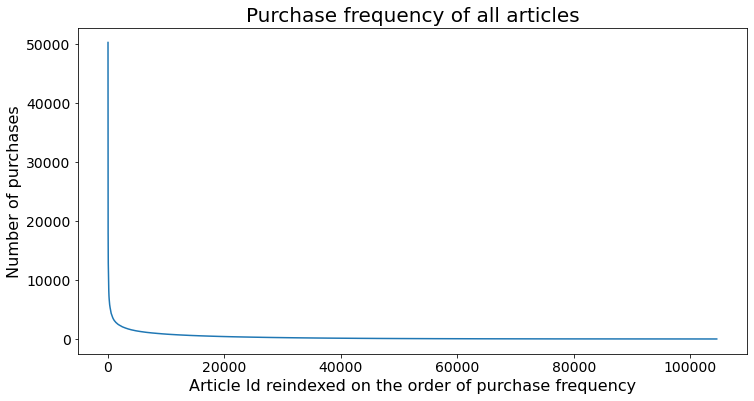

In [19]:
# Plot the purchase frequency of all articles

df_trans.groupby('article_id').size().sort_values(ascending=False).reset_index(drop=True).plot(figsize=(12, 6), fontsize=14)
plt.xlabel("Article Id reindexed on the order of purchase frequency", fontsize=16)
plt.ylabel("Number of purchases", fontsize=16)
plt.title('Purchase frequency of all articles', fontsize=20)

Text(0.5, 1.0, 'Purchase frequency of all customers')

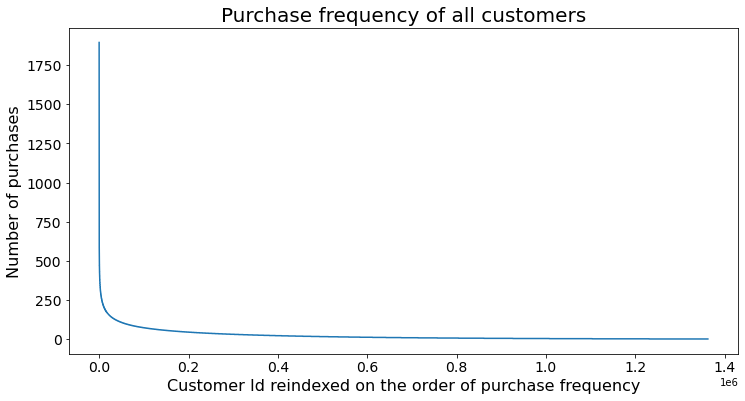

In [20]:
# Plot the purchase frequency of all customers

df_trans.groupby('customer_id').size().sort_values(ascending=False).reset_index(drop=True).plot(figsize=(12, 6), fontsize=14)
plt.xlabel("Customer Id reindexed on the order of purchase frequency", fontsize=16)
plt.ylabel("Number of purchases", fontsize=16)
plt.title('Purchase frequency of all customers', fontsize=20)

***The above two figures of purchase frequency for all articles and customers display a "long tail" distribution. Only a small fraction of the articles are purchased frequently. Such articles are referred to as popular items. The vast majority of articles are purchased rarely. This data is very sparse and data points are mostly from very popular articles and most engaged customers. Large amount of less known articles have very few or don’t have purchases at all. This indicates the existence of the cold-start problem.***

In [21]:
df_trans['t_dat'].max()

Timestamp('2020-09-22 00:00:00')

In [22]:
df_trans['t_dat'].min()

Timestamp('2018-09-20 00:00:00')

***There are about 2 year purchase data. The data amount is huge, we will be using less data.***

In [23]:
# Aggregate monthly purchase numbers.
df_copy = df_trans.copy()
df_copy['year_month'] = df_trans['t_dat'].dt.to_period('M')
df_copy

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id,year_month
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,2,40179,2018-09
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,2,10520,2018-09
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,7,6387,2018-09
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,7,46304,2018-09
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,7,46305,2018-09
...,...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1371691,104961,2020-09
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1371691,100629,2020-09
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1371721,104053,2020-09
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1371747,88521,2020-09


In [24]:
trans_month = df_copy.groupby('year_month').size() 
trans_month

year_month
2018-09     594776
2018-10    1397040
2018-11    1270619
2018-12    1148827
2019-01    1263471
2019-02    1152412
2019-03    1286750
2019-04    1476454
2019-05    1560319
2019-06    1906202
2019-07    1807494
2019-08    1253530
2019-09    1227178
2019-10    1146772
2019-11    1198033
2019-12    1118315
2020-01    1076354
2020-02    1001859
2020-03    1047752
2020-04    1340882
2020-05    1361815
2020-06    1764507
2020-07    1351502
2020-08    1237192
2020-09     798269
Freq: M, dtype: int64

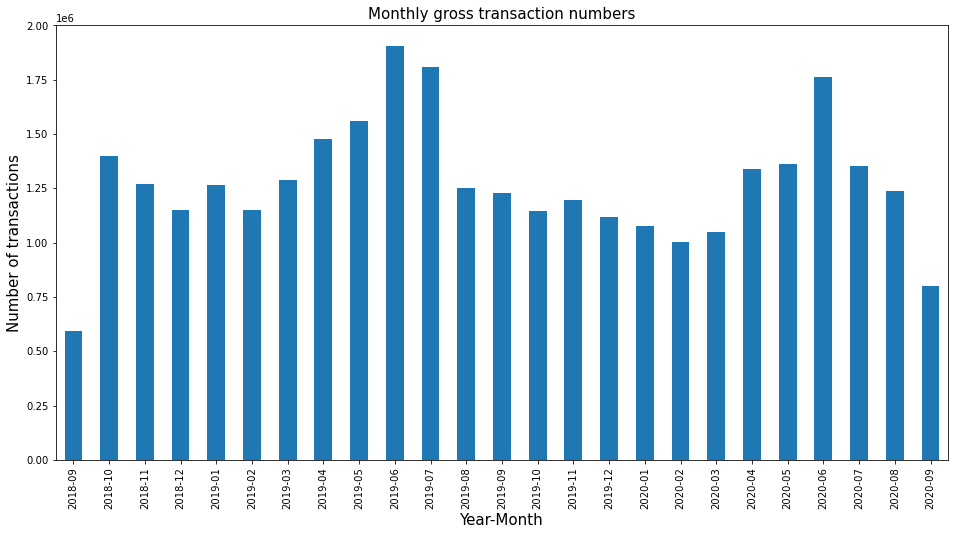

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
trans_month.plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Number of transactions', fontsize=15)
plt.title('Monthly gross transaction numbers', fontsize=15)
plt.show()

***It's clear that there are distinct variations and spikes in the number of transactions for every month. And they follow more or less the same pattern for every year. We see also that sales spikes during spring/summer time and drops during winter.***

***The objective of the project is to predict what items a customer would buy within 7 days after 2020-09-22. If we use all 2 year purchase data, we might need to consider the trend and seasonality within the data. This becomes a time-series problem and makes things more complicated. So, we plan to use short term data.***

***For this reason, considering there are similar transaction numbers in August and September, we will use previous 2 month data from 2020-07-22 to 2020-09-22 to predict future 7 day purchases after 2020-09-22. Please note, the first and last bars for September show incomplete counts as the month was not complete.***

***By choosing data in this way, we avoid the complexity of time-series forecasting, we also avoid the problem such as predicting summer purchase using winter data.***

***Actually, I tried to use the whole 2 year data to predict future purchases. The model performance was bad.***

In [26]:
df = df_trans[df_trans['t_dat'] > '2020-07-21']
df

,t_dat,customer_id,article_id,price,sales_channel_id,user_id,item_id
29314980,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0778064038,0.008458,2,18,74753
29314981,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0817166007,0.006763,2,18,84898
29314982,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0840360002,0.008458,2,18,89863
29314983,2020-07-22,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,0817166003,0.008458,2,18,84897
29314984,2020-07-22,00061a04f030bdf3665b09829192ca8c13c4de6dd9ae9d...,0624486001,0.012729,2,150,28967
...,...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0929511001,0.059305,2,1371691,104961
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,0891322004,0.042356,2,1371691,100629
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,0918325001,0.043203,1,1371721,104053
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,0833459002,0.006763,1,1371747,88521


***Now the number of rows are much smaller.***

**Prepare data and construct the user-item interaction metrix using scipy coo_matrix:**

In [27]:
# We need rows for user_id and columns for item_id, and if a user buy an item, the value is set to 1, otherwise 0
row = df['user_id'].values
col = df['item_id'].values
data = np.ones(df.shape[0])

# construct coo_train using scipy coo_matrix()
coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
coo_train

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 2473344 stored elements in COOrdinate format>

In [28]:
row

array([     18,      18,      18, ..., 1371721, 1371747, 1371960],
      dtype=int64)

In [29]:
col

array([ 74753,  84898,  89863, ..., 104053,  88521, 101689], dtype=int64)

In [30]:
# Calculate sparsity, see https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/

print('Sparsity: {:4.3f}%'.format(float(df.shape[0]) / float(len(ALL_USERS)*len(ALL_ITEMS)) * 100))

Sparsity: 0.002%


***Actually, 0.002% is the density. The sparsity should be 100-0.002% = 99.998%. In industry setting, a density of 0.05% is not so bad. But here we have much less density. Not good. Maybe that's the reason why the overall MAP@12 for these datasets is very low.***

***Note here, we didn't consider the cases where a user repeatedly bought the same item at different time. This could be a point to consider for future model improvement.***

**Try a baseline ALS model to see if it works:**

In [27]:
%%time
model = implicit.als.AlternatingLeastSquares(factors=10, iterations=2)
model.fit(coo_train)

C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(
C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.09702277183532715 seconds
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 674 ms


**Now, we will split data into train and validation (7 days from 2020-09-15 to 2020-09-22), build an ALS model and tune hyperparameters like factors, iterations, regularization using validation set, in order to get best Mean Average Precison @ 12:**

In [28]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse user x item matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    return coo

def split_data(df, validation_days=7):
    """ Split a pandas dataframe into training and validation data, using last 7 days for validation by default
    """
    validation_cut = df['t_dat'].max() - pd.Timedelta(validation_days, 'D')

    df_train = df[df['t_dat'] < validation_cut]
    df_val = df[df['t_dat'] >= validation_cut]
    return df_train, df_val

def get_val_matrices(df, validation_days=7):
    """ Split into training and validation and create various matrices
        
        Returns a dictionary with the following keys:
            csr_train: training data in CSR sparse format and as (users x items)
            csr_val:  validation data in CSR sparse format and as (users x items)
    """
    df_train, df_val = split_data(df, validation_days=validation_days)
    coo_train = to_user_item_coo(df_train)
    coo_val = to_user_item_coo(df_val)

    csr_train = coo_train.tocsr()
    csr_val = coo_val.tocsr()
    
    return csr_train, csr_val

def validate(csr_train, csr_val, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) and <<regularization>>
    for <<iterations>> over csr_train and validate with MAP@12
    """
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=1)
    model.fit(csr_train, show_progress=show_progress)
    
    # The MAP@K in implicit library doesn't allow to calculate repeated items, which is a problem.
    # TODO in the future: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=show_progress)
    print(f"Factors: {factors:>3} - Iterations: {iterations:>2} - Regularization: {regularization:4.3f} ==> MAP@12: {map12:6.5f}")
    return map12

In [29]:
csr_train, csr_val = get_val_matrices(df)

In [30]:
csr_train

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 2155181 stored elements in Compressed Sparse Row format>

In [31]:
csr_val

<1371980x105542 sparse matrix of type '<class 'numpy.float64'>'
	with 29486 stored elements in Compressed Sparse Row format>

In [32]:
%%time

# Fix iteration numbers first, tune factors and regularization for ALS
best_map12 = 0
for factors in [50, 200, 350, 500, 650]:
    for iterations in [5]:
        for regularization in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]:
            map12 = validate(csr_train, csr_val, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors:  50 - Iterations:  5 - Regularization: 0.001 ==> MAP@12: 0.00570
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 5, 'regularization': 0.001}
Factors:  50 - Iterations:  5 - Regularization: 0.010 ==> MAP@12: 0.00571
Best MAP@12 found. Updating: {'factors': 50, 'iterations': 5, 'regularization': 0.01}
Factors:  50 - Iterations:  5 - Regularization: 0.050 ==> MAP@12: 0.00570
Factors:  50 - Iterations:  5 - Regularization: 0.100 ==> MAP@12: 0.00571
Factors:  50 - Iterations:  5 - Regularization: 0.200 ==> MAP@12: 0.00571
Factors:  50 - Iterations:  5 - Regularization: 0.300 ==> MAP@12: 0.00570
Factors: 200 - Iterations:  5 - Regularization: 0.001 ==> MAP@12: 0.00701
Best MAP@12 found. Updating: {'factors': 200, 'iterations': 5, 'regularization': 0.001}
Factors: 200 - Iterations:  5 - Regularization: 0.010 ==> MAP@12: 0.00702
Best MAP@12 found. Updating: {'factors': 200, 'iterations': 5, 'regularization': 0.01}
Factors: 200 - Iterations:  5 - Regularization: 0.050 ==> MA

In [33]:
best_params

{'factors': 350, 'iterations': 5, 'regularization': 0.3}

**Finer tuning based on above result:**

In [34]:
%%time
best_map12 = 0
for factors in [250, 300, 350, 400, 450]:
    for iterations in [5]:
        for regularization in [0.2, 0.25, 0.3, 0.35, 0.4]:
            map12 = validate(csr_train, csr_val, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors: 250 - Iterations:  5 - Regularization: 0.200 ==> MAP@12: 0.00761
Best MAP@12 found. Updating: {'factors': 250, 'iterations': 5, 'regularization': 0.2}
Factors: 250 - Iterations:  5 - Regularization: 0.250 ==> MAP@12: 0.00759
Factors: 250 - Iterations:  5 - Regularization: 0.300 ==> MAP@12: 0.00758
Factors: 250 - Iterations:  5 - Regularization: 0.350 ==> MAP@12: 0.00758
Factors: 250 - Iterations:  5 - Regularization: 0.400 ==> MAP@12: 0.00760
Factors: 300 - Iterations:  5 - Regularization: 0.200 ==> MAP@12: 0.00768
Best MAP@12 found. Updating: {'factors': 300, 'iterations': 5, 'regularization': 0.2}
Factors: 300 - Iterations:  5 - Regularization: 0.250 ==> MAP@12: 0.00769
Best MAP@12 found. Updating: {'factors': 300, 'iterations': 5, 'regularization': 0.25}
Factors: 300 - Iterations:  5 - Regularization: 0.300 ==> MAP@12: 0.00768
Factors: 300 - Iterations:  5 - Regularization: 0.350 ==> MAP@12: 0.00767
Factors: 300 - Iterations:  5 - Regularization: 0.400 ==> MAP@12: 0.00766
F

In [35]:
best_params

{'factors': 300, 'iterations': 5, 'regularization': 0.25}

In [36]:
# Now fix factors and regularization, try to determine best iteration number. Will plot a training curve for visualization

def plot_learning_curve(csr_train, csr_val, factors, iterations, regularization):
    """
    Plot function to show learning curve of ALS
    """
    map12s = []
    for iteration in iterations:
        # train ALS model and calculate map12
        map12 = validate(csr_train, csr_val, factors=factors, iterations=iteration, regularization=regularization, show_progress=False)
        # add to metrics
        map12s.append(map12)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, map12s)
    plt.xlabel('Number of iterations')
    plt.ylabel('Map@12')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

Factors: 300 - Iterations:  1 - Regularization: 0.250 ==> MAP@12: 0.00254
Factors: 300 - Iterations:  2 - Regularization: 0.250 ==> MAP@12: 0.00597
Factors: 300 - Iterations:  3 - Regularization: 0.250 ==> MAP@12: 0.00729
Factors: 300 - Iterations:  4 - Regularization: 0.250 ==> MAP@12: 0.00755
Factors: 300 - Iterations:  5 - Regularization: 0.250 ==> MAP@12: 0.00769
Factors: 300 - Iterations:  6 - Regularization: 0.250 ==> MAP@12: 0.00749
Factors: 300 - Iterations:  7 - Regularization: 0.250 ==> MAP@12: 0.00736
Factors: 300 - Iterations:  8 - Regularization: 0.250 ==> MAP@12: 0.00731
Factors: 300 - Iterations:  9 - Regularization: 0.250 ==> MAP@12: 0.00723
Factors: 300 - Iterations: 10 - Regularization: 0.250 ==> MAP@12: 0.00715
Factors: 300 - Iterations: 11 - Regularization: 0.250 ==> MAP@12: 0.00712
Factors: 300 - Iterations: 12 - Regularization: 0.250 ==> MAP@12: 0.00709
Factors: 300 - Iterations: 13 - Regularization: 0.250 ==> MAP@12: 0.00708
Factors: 300 - Iterations: 14 - Regula

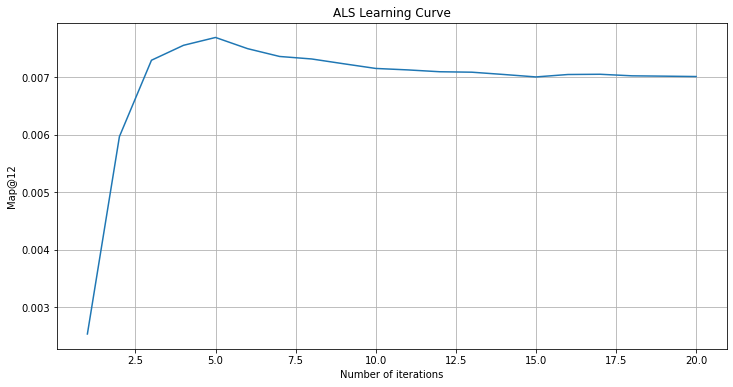

In [37]:
# create an array of iterations
iterations = range(1, 21)
# create learning curve plot
plot_learning_curve(csr_train, csr_val, factors=300, iterations=iterations, regularization=0.25)

***5 iterations gives the best result.***

In [39]:
# Train the tuned model on csr_train and get a MAP@12 metric on csr_val

tuned_model = implicit.als.AlternatingLeastSquares(factors=300, 
                                                 iterations=5, 
                                                 regularization=0.25, 
                                                 random_state=1)
tuned_model.fit(csr_train, show_progress=True)

tuned_map12 = mean_average_precision_at_k(tuned_model, csr_train, csr_val, K=12, show_progress=True)
print(f"Best MAP@12: {tuned_map12}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

Best MAP@12: 0.007685575227911308


**Now, try to apply bm25_weight. See https://benfred.github.io/implicit/tutorial_lastfm.html** 

**Some items are very popular, they tend to dominate the recommendation, this is called popularity bias. We want to direct some of the confidence weight away from those popular items. To do this we can use a bm25 weighting scheme.**

In [53]:
# weight the matrix, to reduce the impact of users that have bought the same article many times,
# and to reduce the weight given to popular items.

bm25_train = bm25_weight(csr_train, K1=100, B=0.8)
bm25_val = bm25_weight(csr_val, K1=100, B=0.8)


In [58]:
# Train a trial model on bm25_train and get a MAP@12 metric on bm25_val

bm25_model = implicit.als.AlternatingLeastSquares(factors=300, 
                                                 iterations=5, 
                                                 regularization=0.25, 
                                                 random_state=1)
bm25_model.fit(bm25_train, show_progress=True)

map12 = mean_average_precision_at_k(bm25_model, bm25_train, bm25_val, K=12, show_progress=True)
print(f"Best MAP@12: {map12}")

C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.021004676818847656 seconds
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

Best MAP@12: 0.009176194305475399


***This looks promising. The MAP@12 improves a lot. We will tune the hyperparameters K1 and B for bm25_weight().***

In [74]:
%%time

def validate_bm25(bm25_train, bm25_val, factors=200, iterations=20, regularization=0.01, show_progress=True):
    """ Train an ALS model with <<factors>> (embeddings dimension) and <<regularization>>
    for <<iterations>> over csr_train and validate with MAP@12
    """
    model = implicit.als.AlternatingLeastSquares(factors=factors, 
                                                 iterations=iterations, 
                                                 regularization=regularization, 
                                                 random_state=1)
    model.fit(bm25_train, show_progress=show_progress)
    
    # The MAP@K in implicit library doesn't allow to calculate repeated items, which is a problem.
    # TODO in the future: change MAP@12 to a library that allows repeated items in prediction
    map12 = mean_average_precision_at_k(model, bm25_train, bm25_val, K=12, show_progress=show_progress)
    print(f"K1: {K1} - B: {B} ==> MAP@12: {map12:6.5f}")
    return map12

best_map12 = 0
for K1 in [0.01, 1, 10, 100]:
    for B in [0.2, 0.4, 0.6, 0.8, 0.95]:
        bm25_train = bm25_weight(csr_train, K1=K1, B=B).tocsr()
        bm25_val = bm25_weight(csr_val, K1=K1, B=B).tocsr()
        map12 = validate_bm25(bm25_train, bm25_val, factors=300, iterations=5, regularization=0.25, show_progress=False)
        if map12 > best_map12:
            best_map12 = map12
            best_params = {'K1': K1, 'B': B}
            print(f"Best MAP@12 found. Updating: {best_params}")

K1: 0.01 - B: 0.2 ==> MAP@12: 0.00985
Best MAP@12 found. Updating: {'K1': 0.01, 'B': 0.2}
K1: 0.01 - B: 0.4 ==> MAP@12: 0.00987
Best MAP@12 found. Updating: {'K1': 0.01, 'B': 0.4}
K1: 0.01 - B: 0.6 ==> MAP@12: 0.00985
K1: 0.01 - B: 0.8 ==> MAP@12: 0.00982
K1: 0.01 - B: 0.95 ==> MAP@12: 0.00984
K1: 1 - B: 0.2 ==> MAP@12: 0.00960
K1: 1 - B: 0.4 ==> MAP@12: 0.00948
K1: 1 - B: 0.6 ==> MAP@12: 0.00952
K1: 1 - B: 0.8 ==> MAP@12: 0.00945
K1: 1 - B: 0.95 ==> MAP@12: 0.00944
K1: 10 - B: 0.2 ==> MAP@12: 0.00953
K1: 10 - B: 0.4 ==> MAP@12: 0.00948
K1: 10 - B: 0.6 ==> MAP@12: 0.00946
K1: 10 - B: 0.8 ==> MAP@12: 0.00919
K1: 10 - B: 0.95 ==> MAP@12: 0.00905
K1: 100 - B: 0.2 ==> MAP@12: 0.00949
K1: 100 - B: 0.4 ==> MAP@12: 0.00944
K1: 100 - B: 0.6 ==> MAP@12: 0.00945
K1: 100 - B: 0.8 ==> MAP@12: 0.00918
K1: 100 - B: 0.95 ==> MAP@12: 0.00898
Wall time: 8min 3s


***It seems K1 and B at higher range are not good. Maybe (not sure), K1=100 and B=0.8 are good for item-user matrix, but here I have user-item matrix. So, probably lower range are good for K1 and B. Do finer tuning.*** 

In [75]:
%%time

best_map12 = 0
for K1 in [0.001, 0.005, 0.01, 0.025, 0.5]:
    for B in [0.1, 0.15, 0.2, 0.25, 0.3]:
        bm25_train = bm25_weight(csr_train, K1=K1, B=B).tocsr()
        bm25_val = bm25_weight(csr_val, K1=K1, B=B).tocsr()
        map12 = validate_bm25(bm25_train, bm25_val, factors=300, iterations=5, regularization=0.25, show_progress=False)
        if map12 > best_map12:
            best_map12 = map12
            best_params = {'K1': K1, 'B': B}
            print(f"Best MAP@12 found. Updating: {best_params}")

K1: 0.001 - B: 0.1 ==> MAP@12: 0.00984
Best MAP@12 found. Updating: {'K1': 0.001, 'B': 0.1}
K1: 0.001 - B: 0.15 ==> MAP@12: 0.00984
K1: 0.001 - B: 0.2 ==> MAP@12: 0.00983
K1: 0.001 - B: 0.25 ==> MAP@12: 0.00985
Best MAP@12 found. Updating: {'K1': 0.001, 'B': 0.25}
K1: 0.001 - B: 0.3 ==> MAP@12: 0.00984
K1: 0.005 - B: 0.1 ==> MAP@12: 0.00985
Best MAP@12 found. Updating: {'K1': 0.005, 'B': 0.1}
K1: 0.005 - B: 0.15 ==> MAP@12: 0.00984
K1: 0.005 - B: 0.2 ==> MAP@12: 0.00985
Best MAP@12 found. Updating: {'K1': 0.005, 'B': 0.2}
K1: 0.005 - B: 0.25 ==> MAP@12: 0.00985
K1: 0.005 - B: 0.3 ==> MAP@12: 0.00986
Best MAP@12 found. Updating: {'K1': 0.005, 'B': 0.3}
K1: 0.01 - B: 0.1 ==> MAP@12: 0.00984
K1: 0.01 - B: 0.15 ==> MAP@12: 0.00986
Best MAP@12 found. Updating: {'K1': 0.01, 'B': 0.15}
K1: 0.01 - B: 0.2 ==> MAP@12: 0.00985
K1: 0.01 - B: 0.25 ==> MAP@12: 0.00986
K1: 0.01 - B: 0.3 ==> MAP@12: 0.00985
K1: 0.025 - B: 0.1 ==> MAP@12: 0.00986
K1: 0.025 - B: 0.15 ==> MAP@12: 0.00987
Best MAP@12 foun

In [76]:
best_params

{'K1': 0.5, 'B': 0.1}

**Use best hyperparameters for bm25 weighting scheme and apply to train and validate data, re-tune hyperparameters for ALS again:**

In [78]:
bm25_train = bm25_weight(csr_train, K1=0.5, B=0.1).tocsr()
bm25_val = bm25_weight(csr_val, K1=0.5, B=0.1).tocsr()

In [79]:
%%time

best_map12 = 0
for factors in [200, 250, 300, 350, 400]:
    for iterations in [5]: 
        for regularization in [0.15, 0.2, 0.25, 0.3, 0.35]:
            map12 = validate(bm25_train, bm25_val, factors, iterations, regularization, show_progress=False)
            if map12 > best_map12:
                best_map12 = map12
                best_params = {'factors': factors, 'iterations': iterations, 'regularization': regularization}
                print(f"Best MAP@12 found. Updating: {best_params}")

Factors: 200 - Iterations:  5 - Regularization: 0.150 ==> MAP@12: 0.00909
Best MAP@12 found. Updating: {'factors': 200, 'iterations': 5, 'regularization': 0.15}
Factors: 200 - Iterations:  5 - Regularization: 0.200 ==> MAP@12: 0.00904
Factors: 200 - Iterations:  5 - Regularization: 0.250 ==> MAP@12: 0.00905
Factors: 200 - Iterations:  5 - Regularization: 0.300 ==> MAP@12: 0.00904
Factors: 200 - Iterations:  5 - Regularization: 0.350 ==> MAP@12: 0.00902
Factors: 250 - Iterations:  5 - Regularization: 0.150 ==> MAP@12: 0.00968
Best MAP@12 found. Updating: {'factors': 250, 'iterations': 5, 'regularization': 0.15}
Factors: 250 - Iterations:  5 - Regularization: 0.200 ==> MAP@12: 0.00968
Best MAP@12 found. Updating: {'factors': 250, 'iterations': 5, 'regularization': 0.2}
Factors: 250 - Iterations:  5 - Regularization: 0.250 ==> MAP@12: 0.00968
Factors: 250 - Iterations:  5 - Regularization: 0.300 ==> MAP@12: 0.00968
Factors: 250 - Iterations:  5 - Regularization: 0.350 ==> MAP@12: 0.00968


In [80]:
best_params

{'factors': 300, 'iterations': 5, 'regularization': 0.35}

**Tune the iteration numbers again:**

Factors: 300 - Iterations:  1 - Regularization: 0.350 ==> MAP@12: 0.00241
Factors: 300 - Iterations:  2 - Regularization: 0.350 ==> MAP@12: 0.00692
Factors: 300 - Iterations:  3 - Regularization: 0.350 ==> MAP@12: 0.00905
Factors: 300 - Iterations:  4 - Regularization: 0.350 ==> MAP@12: 0.00980
Factors: 300 - Iterations:  5 - Regularization: 0.350 ==> MAP@12: 0.01000
Factors: 300 - Iterations:  6 - Regularization: 0.350 ==> MAP@12: 0.00988
Factors: 300 - Iterations:  7 - Regularization: 0.350 ==> MAP@12: 0.00992
Factors: 300 - Iterations:  8 - Regularization: 0.350 ==> MAP@12: 0.00998
Factors: 300 - Iterations:  9 - Regularization: 0.350 ==> MAP@12: 0.01002
Factors: 300 - Iterations: 10 - Regularization: 0.350 ==> MAP@12: 0.01012
Factors: 300 - Iterations: 11 - Regularization: 0.350 ==> MAP@12: 0.01008
Factors: 300 - Iterations: 12 - Regularization: 0.350 ==> MAP@12: 0.01003
Factors: 300 - Iterations: 13 - Regularization: 0.350 ==> MAP@12: 0.01004
Factors: 300 - Iterations: 14 - Regula

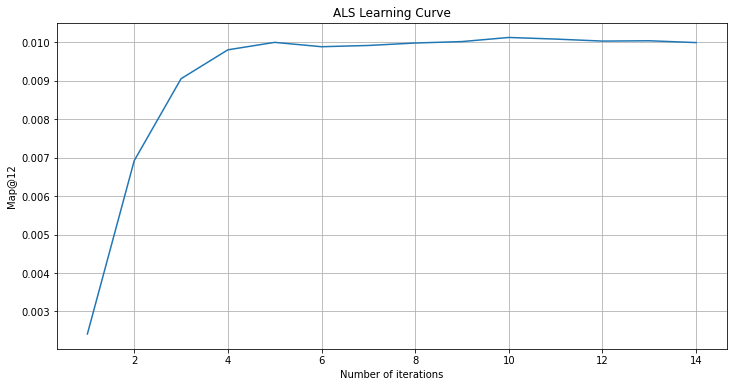

In [82]:
# create an array of iterations
iterations = range(1, 15)
# create learning curve plot
plot_learning_curve(bm25_train, bm25_val, factors=300, iterations=iterations, regularization=0.35)

**10 iterations gives the best MAP@12.**

In [84]:
# Train the best model with best parameter set on bm25_train data and get a MAP@12 metric on bm25_val data

best_model = implicit.als.AlternatingLeastSquares(factors=300, 
                                                 iterations=10, 
                                                 regularization=0.35, 
                                                 random_state=1)
best_model.fit(bm25_train, show_progress=True)

best_map12 = mean_average_precision_at_k(best_model, bm25_train, bm25_val, K=12, show_progress=True)
print(f"Best MAP@12: {best_map12}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

Best MAP@12: 0.010124262092337948


In [31]:
# Train a final model on coo_train (applying bm25 weighting) which will be used for future prediction

bm25_coo_train = bm25_weight(coo_train, K1=0.5, B=0.1).tocsr()

final_model = implicit.als.AlternatingLeastSquares(factors=300, 
                                                 iterations=10, 
                                                 regularization=0.35, 
                                                 random_state=1)
final_model.fit(bm25_coo_train, show_progress=True)


C:\Users\Owner\anaconda3\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/10 [00:02<?, ?it/s]

**Prepare predictions for all the users:**

In [86]:
df_sample = pd.read_csv('data/sample_submission.csv')
df_sample

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...


***The sample submission data contains all the users. So, we need to make predictions for all the users.***

In [42]:
# Will do prediction in batches

def submit(model, csr_train, submission_name="submissions.csv"):
    preds = []
    batch_size = 2000
    to_generate = np.arange(len(ALL_USERS))
    for startidx in range(0, len(to_generate), batch_size):
        batch = to_generate[startidx : startidx + batch_size]
        ids, scores = model.recommend(batch, csr_train[batch], N=12, filter_already_liked_items=False)
        for i, userid in enumerate(batch):
            customer_id = user_ids[userid]
            user_items = ids[i]
            article_ids = [item_ids[item_id] for item_id in user_items]
            preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    df_preds.to_csv(submission_name, index=False)
    
    display(df_preds.head())
    print(df_preds.shape)
    
    return df_preds

In [87]:
%%time
df_preds = submit(final_model, bm25_coo_train);

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0858856005 0762846031 0779781015 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0112679048 0111609001 0111593001 0111586001 01...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321011 0805000001 0794321007 0805000007 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0112679048 0111609001 0111593001 0111586001 01...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0896152002 0791587015 0896152001 07...


(1371980, 2)
Wall time: 11min 58s


Please note, do we need filter_already_liked_items=False? If we don't allow already purchased items, will the MAP@12 be better?

**Recommend 12 products for specified customer_id:**

In [88]:
def recommend_for_user(model, csr_train, customer_id):
    preds = []
    user_id = user_map[customer_id]
    recommend_ids, scores = model.recommend(user_id, csr_train[user_id], N=12, filter_already_liked_items=False)
    article_ids = [item_ids[item_id] for item_id in recommend_ids]
    preds.append((customer_id, ' '.join(article_ids)))

    df_preds = pd.DataFrame(preds, columns=['customer_id', 'prediction'])
    
    return df_preds

In [90]:
%%time

# Given a customer ID, make predictions 
customer_id = '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'
customer_id_preds = recommend_for_user(final_model, bm25_coo_train, customer_id)
customer_id_preds

Wall time: 10 ms


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0858856005 0762846031 0779781015 05...


**Recommend items similar to an item: To achieve this use case, we will create a cosine distance matrix using item embeddings generated by matrix factorization model. This will help us calculate similarity b/w items, and then we can recommend top N similar item to an item of interest.** 

**User inputs an article_id, recommend similar items to him:**

In [184]:
# user inputs an aritcle ID
art_id = '0778064038'

# Get item_id
item_id = item_map[art_id]

# get 10 similar items for user input article
ids, scores= final_model.similar_items(itemid=item_id, N=11)
articles = [item_ids[id] for id in ids]

# display the results using pandas for nicer formatting
similar_articles = pd.DataFrame({"article_id": articles, "score": scores})
similar_articles

,article_id,score
0,0778064038,1.000000
1,0778064045,0.732241
2,0778064028,0.728569
3,0778064041,0.698624
4,0778064006,0.626402
5,0778064018,0.611152
6,0778064001,0.610303
7,0778064029,0.586171
8,0778064003,0.563948
9,0762846010,0.561374


***The first row is the article that user inputs. The other 10 articles are items recommnended.***

Text(0.5, 1.0, 'T-shirt')

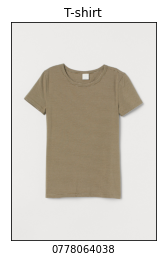

In [185]:
# display the picture of the article user inputs 

fig, ax = plt.subplots()

ax.imshow(plt.imread(f'data/images/{art_id[:3]}/{art_id}.jpg'))
ax.set_xticks([])
ax.set_yticks([])        
ax.set_xlabel(art_id)
ax.set_title(df_item[df_item['article_id'] == art_id].iloc[0,4])


Text(0.5, 0.98, 'Items similar to T-shirt 0778064038')

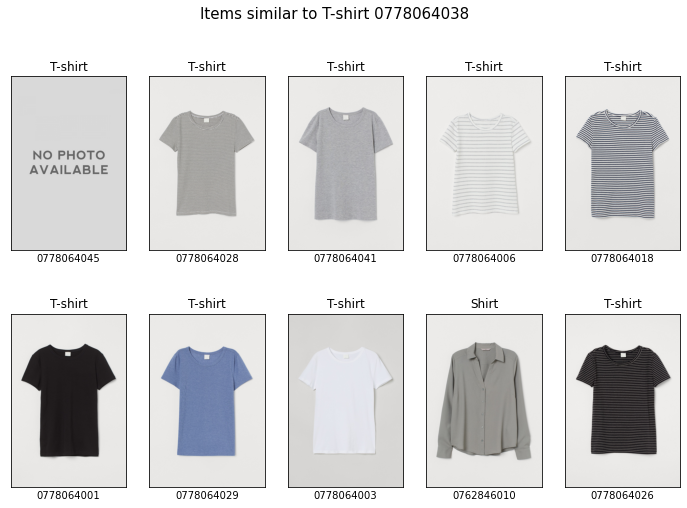

In [186]:
# display all 10 pictures the recommender decides to be similar to the article that user inputs

fig, ax = plt.subplots(2, 5, figsize=(12,8))

for i, article_id in similar_articles.loc[1:, 'article_id'].iteritems():
    try:
        img = plt.imread(f'data/images/{article_id[:3]}/{article_id}.jpg')
        ax.flatten()[i-1].imshow(img)
    except:
        ax.flatten()[i-1].imshow(plt.imread('data/image-not-available.jpg'))

    ax.flatten()[i-1].set_xticks([])
    ax.flatten()[i-1].set_yticks([])        
    ax.flatten()[i-1].set_xlabel(article_id)
    
    # Find article's product_type_name
    product_type_name = df_item[df_item['article_id'] == article_id].iloc[0,4]
    ax.flatten()[i-1].set_title(product_type_name)
    
plt.suptitle(f'Items similar to {df_item[df_item["article_id"] == art_id].iloc[0,4]} {art_id}', fontsize=15)


***We can see that user inputs an article id for a T-shirt, and the recommender does recommend 9 similar T-shirts and 1 shirt. Looks not bad.***

Is there a way to recommend an item to a list of users???

In [2]:
# This one is using LightFM, may not be used here

# def sample_recommendation_item(model,interactions,item_id,user_dict,item_dict,number_of_user):
#     '''
#     Funnction to produce a list of top N interested users for a given item
#     Required Input -
#         - model = Trained matrix factorization model
#         - interactions = dataset used for training the model
#         - item_id = item ID for which we need to generate recommended users
#         - user_dict =  Dictionary type input containing interaction_index as key and user_id as value
#         - item_dict = Dictionary type input containing item_id as key and item_name as value
#         - number_of_user = Number of users needed as an output
#     Expected Output -
#         - user_list = List of recommended users 
#     '''
#     n_users, n_items = interactions.shape
#     x = np.array(interactions.columns)
#     scores = pd.Series(model.predict(np.arange(n_users), np.repeat(x.searchsorted(item_id),n_users)))
#     user_list = list(interactions.index[scores.sort_values(ascending=False).head(number_of_user).index])
#     return user_list 

# Maybe we can just transpose the interaction coo_matrix, retrain the model and get recommendation list of users instead of items???

In [33]:
# Save the final model for future prediction

import pickle

with open('final_model.pkl', "wb") as out_file:
    pickle.dump(final_model, out_file)
        
# with open(file_name, "rb") as in_file:
#     model_saved = pickle.load(in_file)

In [39]:
# Save the user and item map and ids for future prediction

with open('user_map.pkl', "wb") as out_file:
    pickle.dump(user_map, out_file)

with open('user_ids.pkl', "wb") as out_file:
    pickle.dump(user_ids, out_file)

with open('item_map.pkl', "wb") as out_file:
    pickle.dump(item_map, out_file)
    
with open('item_ids.pkl', "wb") as out_file:
    pickle.dump(item_ids, out_file)


In [36]:
# Save training data for future prediction

with open('bm25_coo_train.pkl', "wb") as out_file:
    pickle.dump(bm25_coo_train, out_file)

**Next will try to build a content-based recommender, and compare the performance with the ALS model.**

**Try some codes for Flask.**

In [34]:
flask_model = pickle.load(open('final_model.pkl', 'rb'))  # opening pickle file in read mode

In [40]:
flask_user_map = pickle.load(open('user_map.pkl', 'rb'))
flask_user_ids = pickle.load(open('user_ids.pkl', 'rb'))
flask_item_map = pickle.load(open('item_map.pkl', 'rb'))
flask_item_ids = pickle.load(open('item_ids.pkl', 'rb'))

In [37]:
flask_bm25_coo_train  = pickle.load(open('bm25_coo_train.pkl', 'rb'))

In [44]:
def recommend_for_user(customer_id):
    """Given a customer ID, generate recommended a list of items in the pattern [customerid, item_ids].
    A sample customer_id is '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'

    Args:
        user_id (int): user id
        movie_id (int): movie_id that the user watched
        number_movies (int): number of movies to return
    Returns:
        a list of list. Each pair follows the pattern [movie_id, movie_name]
    """

    user_id = flask_user_map[customer_id]
    recommend_ids, scores = flask_model.recommend(user_id, flask_bm25_coo_train[user_id], N=12, filter_already_liked_items=False)
    article_ids = [flask_item_ids[item_id] for item_id in recommend_ids]
    
    # return (customer_id, article_ids)
    print(customer_id, article_ids)

customer_id = '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'
recommend_for_user(customer_id)

00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657 ['0568601043', '0858856005', '0762846031', '0568601006', '0779781015', '0568601007', '0889661001', '0716670009', '0568601030', '0568597007', '0728156024', '0896064002']


In [47]:
def recommend_for_item(art_id, num):
    # Get item_id
    item_id = flask_item_map[art_id]

    # get 10 similar items for user input article
    ids, scores= flask_model.similar_items(itemid=item_id, N=num+1)
    articles = [flask_item_ids[id] for id in ids]

    print(articles[1:])
    
art_id = '0778064038'
num = 12
recommend_for_item(art_id, num)

['0778064028', '0778064045', '0778064041', '0778064018', '0778064006', '0778064029', '0778064001', '0762846010', '0778064026', '0778064003', '0778064051', '0702196004']


**In implicit library specifically developed for collaborative filtering system, there are several popular recommender algorithms for implicit feedback datasets. See here: https://implicit.readthedocs.io/en/latest/**

**Will build those models one by one and compare their performaces:**


In [206]:
%%time

import time
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

# Train many models using various recommenders in implicit library

for model_name in['als', 'bpr', 'lmf', 'tfidf', 'cosine', 'bm25']:
    
    # generate a recommender model based off the input params
    if model_name == "als":
        model = AlternatingLeastSquares()

        # lets weight these models by bm25weight.
        csr_train = bm25_weight(csr_train, K1=0.5, B=0.1).tocsr()

    elif model_name == "bpr":
        model = BayesianPersonalizedRanking()

    elif model_name == "lmf":
        model = LogisticMatrixFactorization()

    elif model_name == "tfidf":
        model = TFIDFRecommender()

    elif model_name == "cosine":
        model = CosineRecommender()

    elif model_name == "bm25":
        model = BM25Recommender(K1=0.5, B=0.1)

    # train the model
    start = time.time()
    print("training model %s" % model_name)
    model.fit(csr_train)

    # calculate MAP@12
    map12 = mean_average_precision_at_k(model, csr_train, csr_val, K=12, show_progress=True)
    print(f"MAP@12 for {model_name}: {map12}")
    print("trained model %s in %s" % (model_name, time.time()-start))


training model als


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for als: 0.008936084351097266
trained model als in 19.0412175655365
training model bpr


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for bpr: 0.004352458209689272
trained model bpr in 31.708024740219116
training model lmf


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for lmf: 0.0010728229611208335
trained model lmf in 25.734702587127686
training model tfidf


C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.023005008697509766 seconds
  warnings.warn(


  0%|          | 0/105542 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for tfidf: 0.00350377513813978
trained model tfidf in 1.4092602729797363
training model cosine


C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.019004344940185547 seconds
  warnings.warn(


  0%|          | 0/105542 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for cosine: 0.0034088635503045617
trained model cosine in 1.3520560264587402
training model bm25


C:\Users\jliu1\anaconda3\lib\site-packages\implicit\utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.02000570297241211 seconds
  warnings.warn(


  0%|          | 0/105542 [00:00<?, ?it/s]

  0%|          | 0/10528 [00:00<?, ?it/s]

MAP@12 for bm25: 0.0052752396445744955
trained model bm25 in 1.3679156303405762
Wall time: 1min 20s


***ALS model gives the best result even without hyperparameter tuning. So, stick to ALS model.***